# Experiment 1: Fine-Tuning / From Scratch Training

In [2]:
import pandas as pd
import pyvista as pv

In [2]:
results = pd.read_csv("../eval/TestEvaluation/mesh_eval_results.csv")

# print all models unqieu in csv

re_models = results["model"].unique()
print(re_models)

['pix2vox_aug' 'pix2vox_aug_1img' 'pix2vox_aug_3img' 'pix2vox_aug_4img'
 'pix2vox_aug_5img' 'pix2vox_aug_6img' 'pix2vox_aug_frozen_encdec'
 'pix2vox_base' 'pix2vox_non_pretrained' 'vh_1img' 'vh_2img' 'vh_3img'
 'vh_4img' 'vh_5img' 'vh_6img' 'coarse_mvp2m_2_inputs_none_augmentation'
 'coarse_mvp2m_augmentation_2_inputs'
 'coarse_mvp2m_augmentation_2_inputs_freezed'
 'coarse_mvp2m_augmentation_2_inputs_pretrained'
 'coarse_mvp2m_augmentation_2_inputs_use_mean_prior'
 'coarse_mvp2m_augmentation_2_inputs_use_spherical_prior'
 'coarse_mvp2m_augmentation_3_inputs' 'coarse_mvp2m_augmentation_4_inputs'
 'coarse_mvp2m_augmentation_5_inputs' 'coarse_mvp2m_augmentation_6_inputs'
 'Hunyuan3D' 'Hunyuan3D-four-views' 'Hunyuan3D-two-views'
 'Pixel2Mesh_Augmented_2_Views' 'pollen_128_2' 'pollen_256_2'
 'pollen_augmentation1' 'pollen_augmentation2' 'pollen_augmentation3'
 'pollen_augmentation4' 'pollen_augmentation6'
 'pollen_augmentation_finetune' 'pollen_augmentation_freezed'
 'pollen_augmentation_no

In [3]:
relevant_models = [
    "vh_2img",   
    "pix2vox_aug",
    "pix2vox_aug_frozen_encdec",
    "pix2vox_non_pretrained",
    "pollen_augmentation_finetune",
    "pollen_augmentation_freezed",
    "pollen_none_pretrained",
    "refine_p2mpp_augmentation_2_inputs",
    "refine_p2mpp_augmentation_2_inputs_freezed",
    "refine_p2mpp_augmentation_2_inputs_pretrained",
]

filtered = results[results["model"].isin(relevant_models)]

aggregated = filtered.groupby("model", as_index=False).agg(
    mean_chamfer         = ("chamfer",     "mean"),
    std_chamfer          = ("chamfer",     "std"),
    mean_fscore_1        = ("fscore_1",    "mean"),
    std_fscore_1         = ("fscore_1",    "std"),
    mean_fscore_2_5      = ("fscore_2_5",  "mean"),
    std_fscore_2_5       = ("fscore_2_5",  "std"),
    mean_fscore_5        = ("fscore_5",    "mean"),
    std_fscore_5         = ("fscore_5",    "std"),
    mean_iou             = ("voxel_iou",   "mean"),
    std_iou              = ("voxel_iou",   "std"),
)

aggregated

model  mean_chamfer  std_chamfer  \
0                                    pix2vox_aug      0.059839     0.020741   
1                      pix2vox_aug_frozen_encdec      0.056526     0.017044   
2                         pix2vox_non_pretrained      0.063499     0.018741   
3                   pollen_augmentation_finetune      0.044596     0.016757   
4                    pollen_augmentation_freezed      0.059333     0.015406   
5                         pollen_none_pretrained      0.044786     0.018491   
6             refine_p2mpp_augmentation_2_inputs      0.051909     0.022576   
7     refine_p2mpp_augmentation_2_inputs_freezed      0.051375     0.025330   
8  refine_p2mpp_augmentation_2_inputs_pretrained      0.052216     0.021743   
9                                        vh_2img      0.091423     0.024904   

   mean_fscore_1  std_fscore_1  mean_fscore_2_5  std_fscore_2_5  \
0       0.166688      0.060798         0.603350        0.151200   
1       0.180305      0.063962         0.619251        0.149610   
2       0.148749      0.046822         0.568961        0.138251   
3       0.257467      0.088129         0.755981        0.152617   
4       0.176354      0.065748         0.623380        0.092378   
5       0.261999      0.114809         0.759020        0.165802   
6       0.212900      0.090377         0.690881        0.155863   
7       0.216349      0.091418         0.687749        0.159364   
8       0.216471      0.096116         0.687208        0.154837   
9       0.109239      0.040237         0.416278        0.101777   

   mean_fscore_5  std_fscore_5  mean_iou   std_iou  
0       0.848221      0.121432  0.713982  0.176484  
1       0.850548      0.099744  0.678091  0.139773  
2       0.819073      0.118238  0.722673  0.109763  
3       0.904351      0.096696  0.823766  0.071286  
4       0.827504      0.097487  0.792415  0.077769  
5       0.900828      0.106800  0.825780  0.083049  
6       0.884539      0.124626  0.406086  0.234189  
7       0.886603      0.139626  0.763154  0.117579  
8       0.879575      0.119737  0.769657  0.110282  
9       0.664201      0.120545  0.637425  0.090634

In [3]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import numpy as np
import matplotlib.pyplot as plt
import sys
import trimesh

sys.path.append("../")

from TestEvaluationPipeline.mesh_utils import MeshUtils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
def set_axes_equal_and_zoom(ax, mesh, zoom=1.5):
    # get raw extents
    xyz = mesh.vertices
    x_min, y_min, z_min = xyz.min(axis=0)
    x_max, y_max, z_max = xyz.max(axis=0)
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    z_mid = (z_min + z_max) / 2

    # half‐size of the largest span
    half_size = max(x_max-x_min, y_max-y_min, z_max-z_min) * zoom / 2

    # set equal aspect box, zoomed out by factor zoom
    ax.set_xlim(x_mid - half_size, x_mid + half_size)
    ax.set_ylim(y_mid - half_size, y_mid + half_size)
    ax.set_zlim(z_mid - half_size, z_mid + half_size)

    # optional: force truly equal aspect
    ax.set_box_aspect((1,1,1))

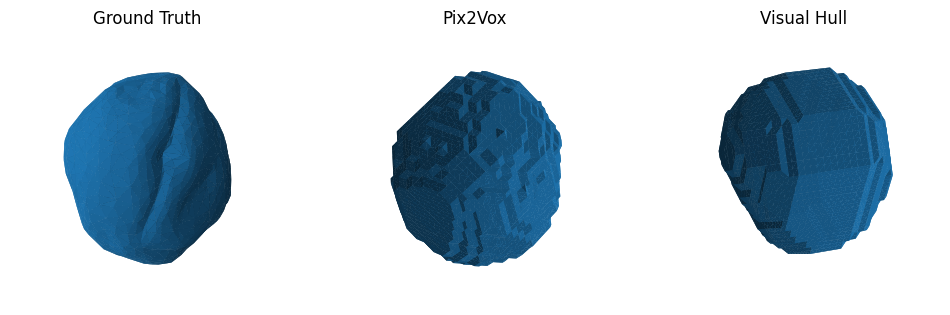

In [6]:
gt   = trimesh.load("../data/processed/meshes/17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl")
pred = trimesh.load("../TestEvaluationPipeline/data/pix2vox_aug/17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl")
pred2 = trimesh.load("../TestEvaluationPipeline/data/vh_6img/17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl")

mesh_aligned, _ = MeshUtils.align_icp(pred, gt)
mesh_aligned2, _ = MeshUtils.align_icp(pred2, gt)
rebuilt = trimesh.Trimesh(vertices=mesh_aligned.vertices,
                          faces    =pred.faces)
rebuilt2 = trimesh.Trimesh(vertices=mesh_aligned2.vertices,
                          faces    =pred2.faces)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

for ax in (ax1, ax2, ax3):
    ax.grid(False)
    ax.xaxis.pane.fill   = False
    ax.yaxis.pane.fill   = False
    ax.zaxis.pane.fill   = False
    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')

    ax.set_axis_off()

ax1.set_title("Ground Truth")
ax2.set_title("Pix2Vox")
ax3.set_title("Visual Hull")

ax1.plot_trisurf(gt.vertices[:,0], gt.vertices[:,1], gt.vertices[:,2],
                 triangles=gt.faces)
ax2.plot_trisurf(rebuilt.vertices[:,0], rebuilt.vertices[:,1], rebuilt.vertices[:,2],
                 triangles=rebuilt.faces)
ax3.plot_trisurf(rebuilt2.vertices[:,0], rebuilt2.vertices[:,1], rebuilt2.vertices[:,2],
                 triangles=rebuilt2.faces)

set_axes_equal_and_zoom(ax1, gt,     zoom=0.8)
set_axes_equal_and_zoom(ax2, rebuilt, zoom=0.8)
set_axes_equal_and_zoom(ax3, rebuilt2,zoom=0.8)

plt.show()

In [4]:
import os
from pathlib import Path
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from TestEvaluationPipeline.mesh_utils import MeshUtils
import fast_simplification

def set_axes_equal_and_zoom(ax, mesh, zoom=1.0):
    # Compute center & size
    xyz = mesh.vertices
    mins = xyz.min(axis=0)
    maxs = xyz.max(axis=0)
    center = (mins + maxs) / 2
    half = (maxs - mins).max() * zoom / 2

    # Apply to axes
    ax.set_xlim(center[0] - half, center[0] + half)
    ax.set_ylim(center[1] - half, center[1] + half)
    ax.set_zlim(center[2] - half, center[2] + half)
    ax.set_box_aspect((1, 1, 1))

def find_mesh_file(model_dir, base_name, exts=(".stl", ".obj")):
    """
    Look for a file in model_dir whose name contains base_name and ends with one of the given extensions.
    """
    base = Path(model_dir)
    # try scanning for any file matching pattern *base_name*ext
    for ext in exts:
        pattern = f"*{base_name}*{ext}"
        matches = list(base.glob(pattern))
        if matches:
            return str(matches[0])
    # fallback to any file containing base_name
    globbed = list(base.glob(f"*{base_name}*.*"))
    if globbed:
        return str(globbed[0])
    raise FileNotFoundError(f"No mesh file containing '{base_name}' in '{model_dir}'")

def set_axes_equal_and_zoom(ax, mesh, zoom=1.0):
    xyz = mesh.vertices
    mins = xyz.min(axis=0)
    maxs = xyz.max(axis=0)
    center = (mins + maxs) / 2
    half = (maxs - mins).max() * zoom / 2

    ax.set_xlim(center[0] - half, center[0] + half)
    ax.set_ylim(center[1] - half, center[1] + half)
    ax.set_zlim(center[2] - half, center[2] + half)
    ax.set_box_aspect((1, 1, 1))


def plot_mesh_grid(
    basenames,
    model_dirs,
    model_names=None,
    exts=(".stl", ".obj"),
    zoom=0.8,
    figsize=(12, 6),
    color=None
):
    """
    basenames    : list of mesh name substrings WITHOUT extension
    model_dirs   : list of directory paths (first one = GT)
    model_names  : optional list of column titles
    exts         : tuple of extensions to try (default .stl and .obj)
    zoom         : <1 zooms in (meshes look larger), >1 zooms out
    figsize      : figure size for plt.figure
    """
    n_rows = len(basenames)
    n_cols = len(model_dirs)

    if model_names is None:
        model_names = [os.path.basename(os.path.normpath(d)) for d in model_dirs]

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        subplot_kw={"projection": "3d"},
        figsize=figsize,
        squeeze=False
    )

    for i, name in enumerate(basenames):
        # load GT for this row
        gt_path = find_mesh_file(model_dirs[0], name, exts)
        gt = trimesh.load(gt_path)

        for j, model_dir in enumerate(model_dirs):
            ax = axes[i, j]
            # styling
            ax.grid(False)
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            for spine in (ax.xaxis, ax.yaxis, ax.zaxis):
                spine.pane.set_edgecolor("none")
            ax.set_axis_off()

            # load & align or just use GT
            if j == 0:
                mesh = gt
            else:
                pred_path = find_mesh_file(model_dir, name, exts)
                pred = trimesh.load(pred_path)
                if pred.vertices.shape[0] >= 10_000:
                    new_verts, new_faces = fast_simplification.simplify(points=pred.vertices.view(np.ndarray),
                                                                        triangles=pred.faces.view(np.ndarray), 
                                                                        target_reduction=0.999999)
                    pred = trimesh.Trimesh(vertices=new_verts, faces=new_faces)
                aligned, _ = MeshUtils.align_icp(pred, gt)
                mesh = trimesh.Trimesh(vertices=aligned.vertices, faces=pred.faces)

            # plot
            ax.plot_trisurf(
                mesh.vertices[:, 0],
                mesh.vertices[:, 1],
                mesh.vertices[:, 2],
                triangles=mesh.faces,
                color=color
            )

            # title on first row
            if i == 0:
                ax.set_title(model_names[j])

            # equal aspect & zoom
            set_axes_equal_and_zoom(ax, mesh, zoom=zoom)

    plt.tight_layout()
    plt.show()


In [9]:
filenames = [
    "17781_Common_thyme_Thymus_vulgaris_pollen_grain",
    "17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain",
    "21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken",
    "21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain",
    "17878_Alder_Alnus_sp_pollen_grain_pentaporate"
]

## Pix2Vox

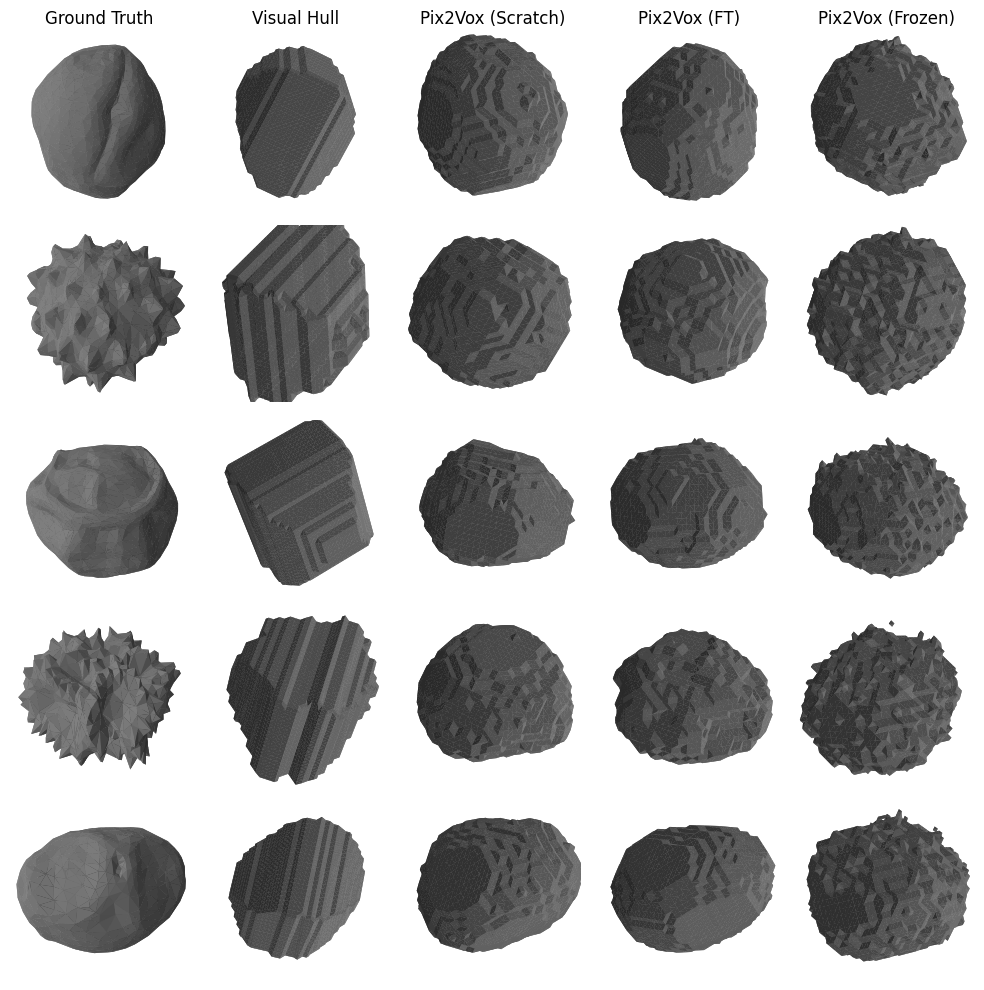

In [ ]:
model_dirs = [
    "../data/processed/meshes", 
    "../TestEvaluationPipeline/data/vh_2img",
    "../TestEvaluationPipeline/data/pix2vox_non_pretrained",
    "../TestEvaluationPipeline/data/pix2vox_aug",
    "../TestEvaluationPipeline/data/pix2vox_aug_frozen_encdec",
]

model_names = ["Ground Truth", 
               "Visual Hull", 
               "Pix2Vox (Scratch)", 
               "Pix2Vox (FT)", 
               "Pix2Vox (Frozen)"]

plot_mesh_grid(filenames, model_dirs, model_names, zoom=0.65, figsize=(10, 10))

## PixelNeRF

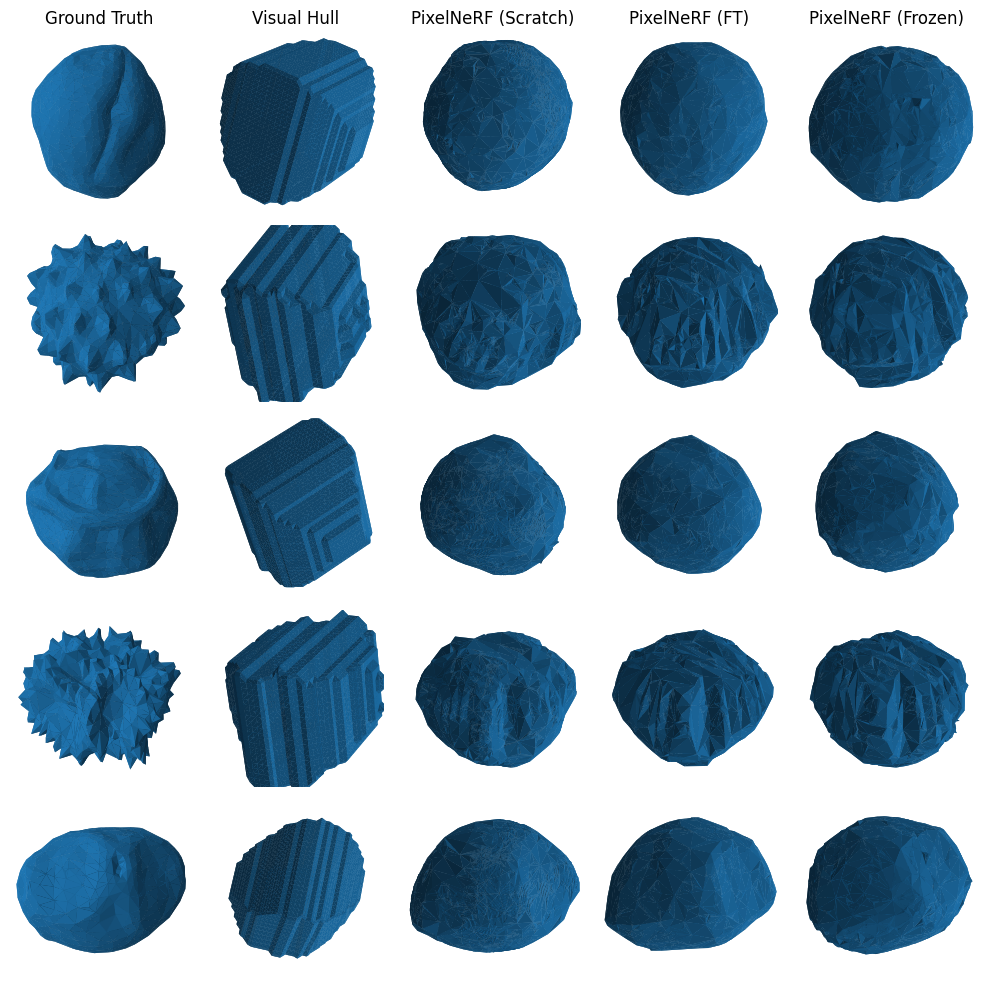

In [ ]:
model_dirs = [
    "../data/processed/meshes", 
    "../TestEvaluationPipeline/data/vh_2img",
    "../TestEvaluationPipeline/data/pollen_none_pretrained",
    "../TestEvaluationPipeline/data/pollen_augmentation_finetune",
    "../TestEvaluationPipeline/data/pollen_augmentation_freezed",
]

model_names = ["Ground Truth", 
               "Visual Hull", 
               "PixelNeRF (Scratch)", 
               "PixelNeRF (FT)", 
               "PixelNeRF (Frozen)"]

plot_mesh_grid(filenames, model_dirs, model_names, zoom=0.65, figsize=(10, 10))

## Pixel2Mesh++

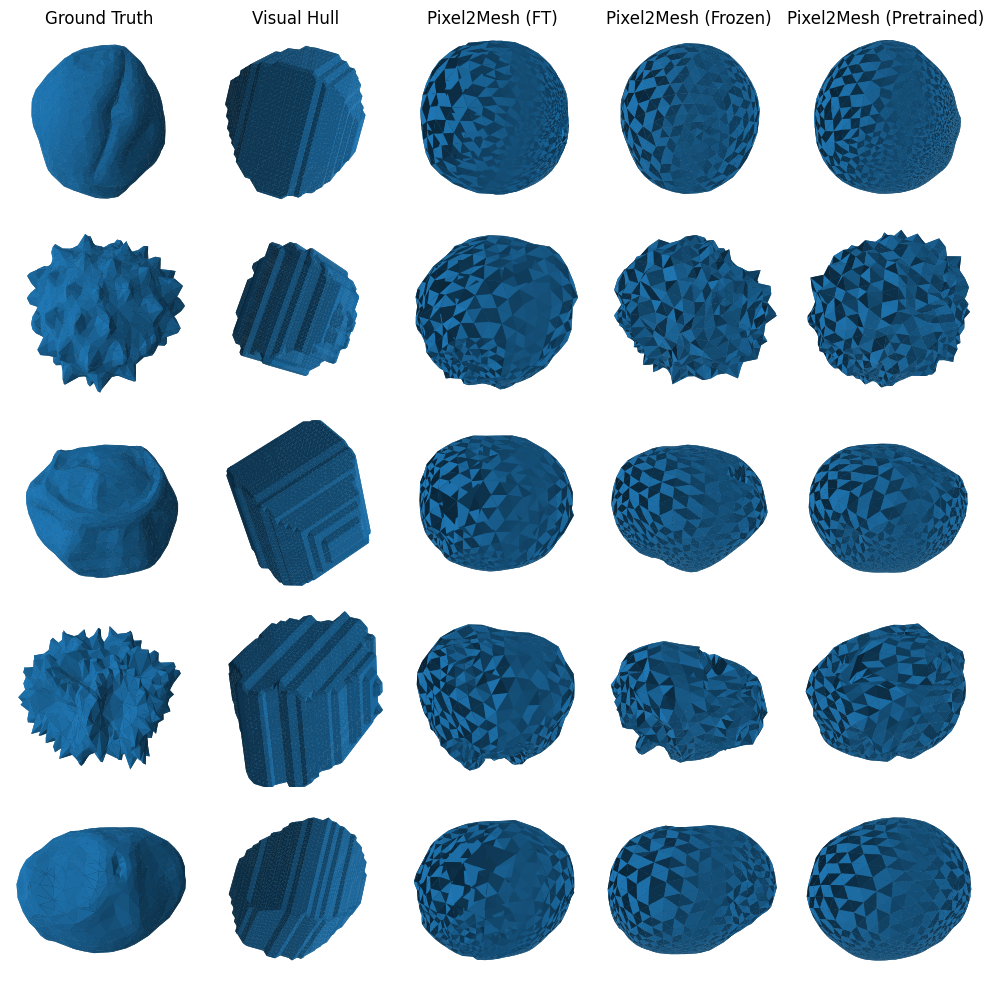

In [ ]:
model_dirs = [
    "../data/processed/meshes", 
    "../TestEvaluationPipeline/data/vh_2img",
    "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs",
    "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs_freezed",
    "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs_pretrained",
]

model_names = ["Ground Truth", 
               "Visual Hull", 
               "Pixel2Mesh (FT)", 
               "Pixel2Mesh (Frozen)", 
               "Pixel2Mesh (Pretrained)"]

plot_mesh_grid(filenames, model_dirs, model_names, zoom=0.65, figsize=(10, 10))

## Summarizing Overview

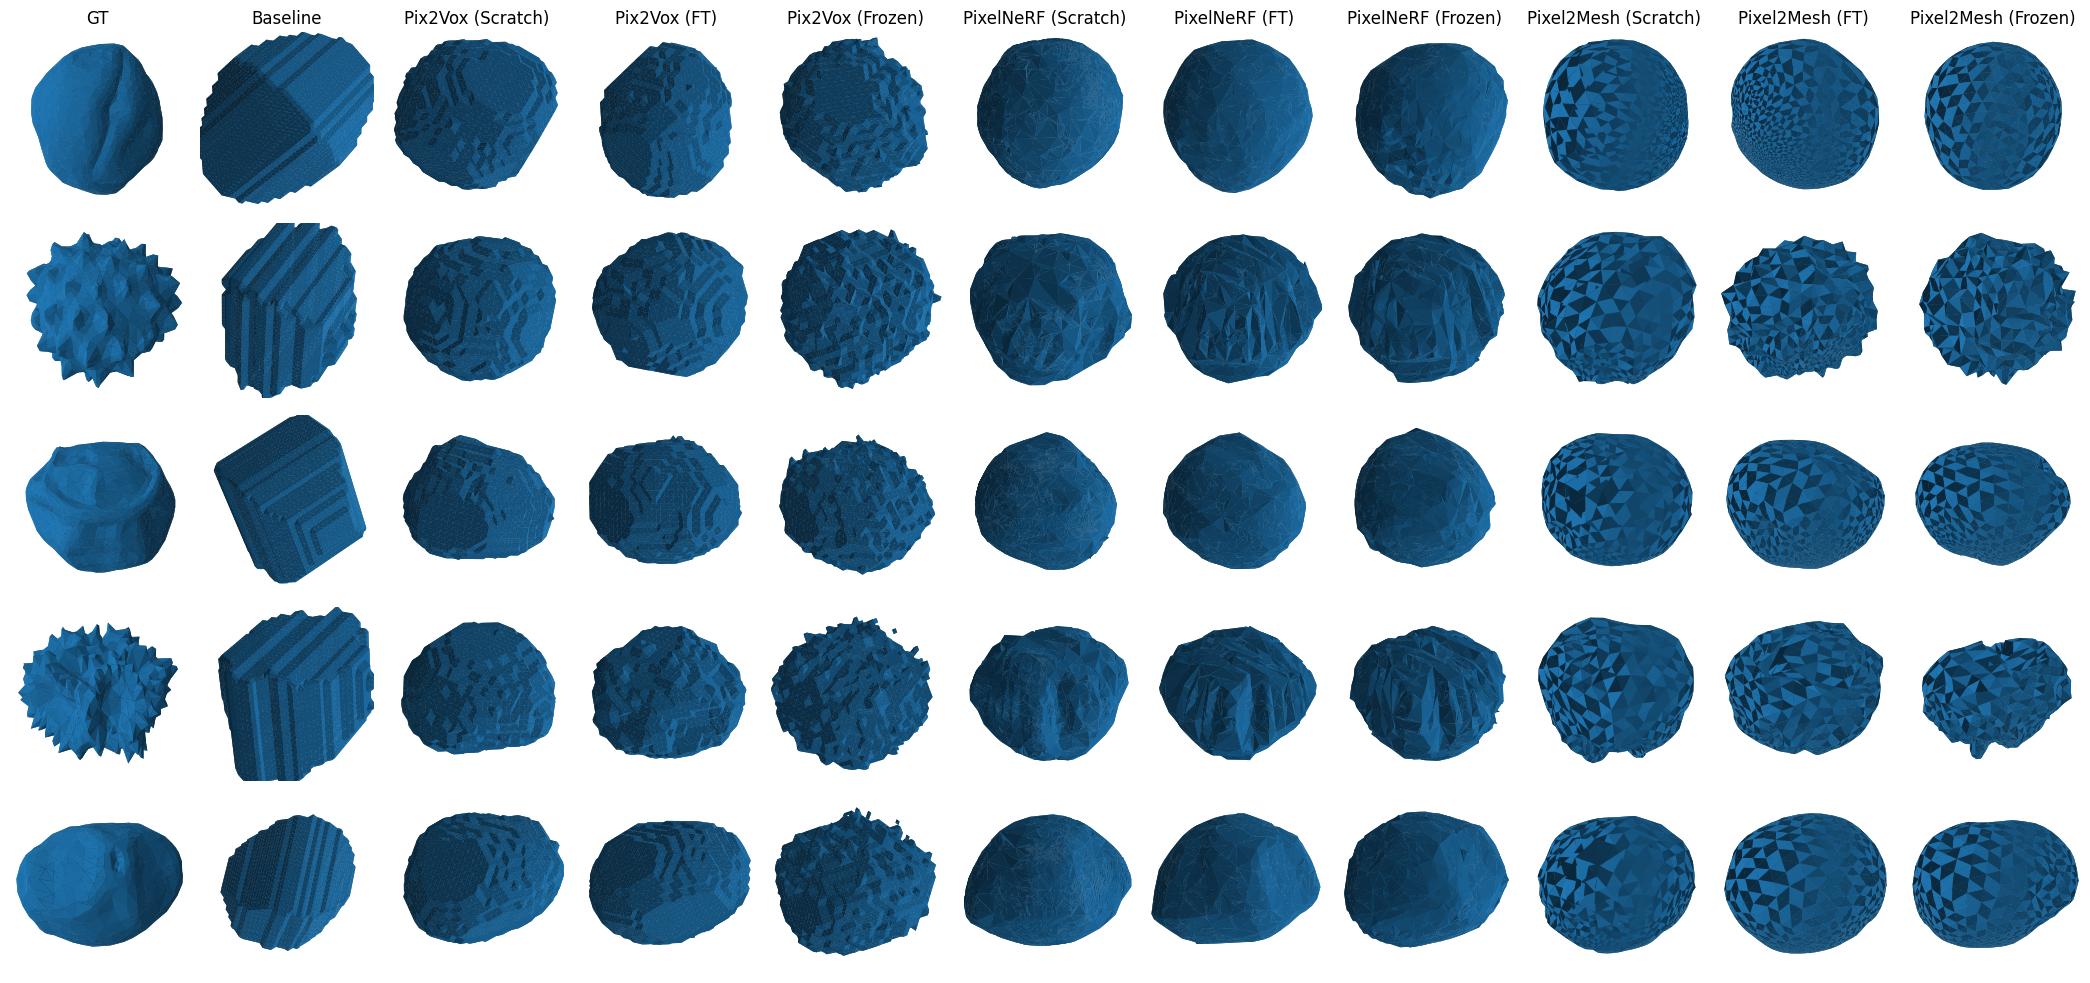

In [10]:
model_dirs = [
    "../data/processed/meshes", 
    "../TestEvaluationPipeline/data/vh_2img",
    "../TestEvaluationPipeline/data/pix2vox_non_pretrained",
    "../TestEvaluationPipeline/data/pix2vox_aug",
    "../TestEvaluationPipeline/data/pix2vox_aug_frozen_encdec",
    "../TestEvaluationPipeline/data/pollen_none_pretrained",
    "../TestEvaluationPipeline/data/pollen_augmentation_finetune",
    "../TestEvaluationPipeline/data/pollen_augmentation_freezed",
    "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs",
    "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs_pretrained",
    "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs_freezed",
]

model_names = ["GT", 
               "Baseline",
               "Pix2Vox (Scratch)", 
               "Pix2Vox (FT)", 
               "Pix2Vox (Frozen)",
               "PixelNeRF (Scratch)", 
               "PixelNeRF (FT)", 
               "PixelNeRF (Frozen)",
               "Pixel2Mesh (Scratch)", 
               "Pixel2Mesh (FT)", 
               "Pixel2Mesh (Frozen)"]

plot_mesh_grid(filenames, model_dirs, model_names, zoom=0.65, figsize=(21, 10))

In [17]:
mesh = trimesh.load("../data/processed/meshes/20710_Broad_leaved_lime_Tilia_platyphyllos_pollen_grain.stl")

In [18]:
mesh.show()

In [ ]:
mesh_in = trimesh.load(os.path.join(model_dirs[-1], "pollen_17782_Golden-ray_lily_Lilium_auratum_pollen_grain_00_predict.obj"))

In [ ]:
mesh_in.show()

In [ ]:
new_verts, new_faces = fast_simplification.simplify(points=mesh_in.vertices.view(np.ndarray),
                             triangles=mesh_in.faces.view(np.ndarray), target_count=1_000)

In [ ]:
new_mesh = trimesh.Trimesh(vertices=new_verts, faces=new_faces)

In [ ]:
new_mesh.vertices

TrackedArray([[-0.63048699,  0.06092973,  0.01564868],
              [-0.63658734,  0.02648562, -0.02290301],
              [-0.59284219,  0.09153735, -0.06752264],
              ...,
              [ 0.60140685, -0.11498367,  0.02686324],
              [ 0.60069602, -0.10952077,  0.03129528],
              [ 0.61029752, -0.14839833,  0.05100215]], shape=(12030, 3))